# Comparison of results of the *pendulum* system and choice of *hyper parameters*. 

In [112]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import sys
sys.path.insert(0, '../')

from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from tensorflow.keras.models import model_from_json
from data.Data import DataMaker
from return_stats import *
from create_plots import *
from dmd_functions import *
from tensorflow import keras
import pickle
import numpy as np
from pydmd import DMD
from numpy import matlib

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

# Read in 10 pendulum trajectories. 

In [114]:
rings = np.loadtxt('../data/PendulumRings.csv', delimiter=',')
test_data = rings.reshape((rings.shape[0], int(rings.shape[1]/2), 2))
test_data = tf.cast(test_data, dtype=tf.float32)
test_data = tf.transpose(test_data, perm=[0, 2, 1])
print(test_data.shape)

(10, 2, 1500)


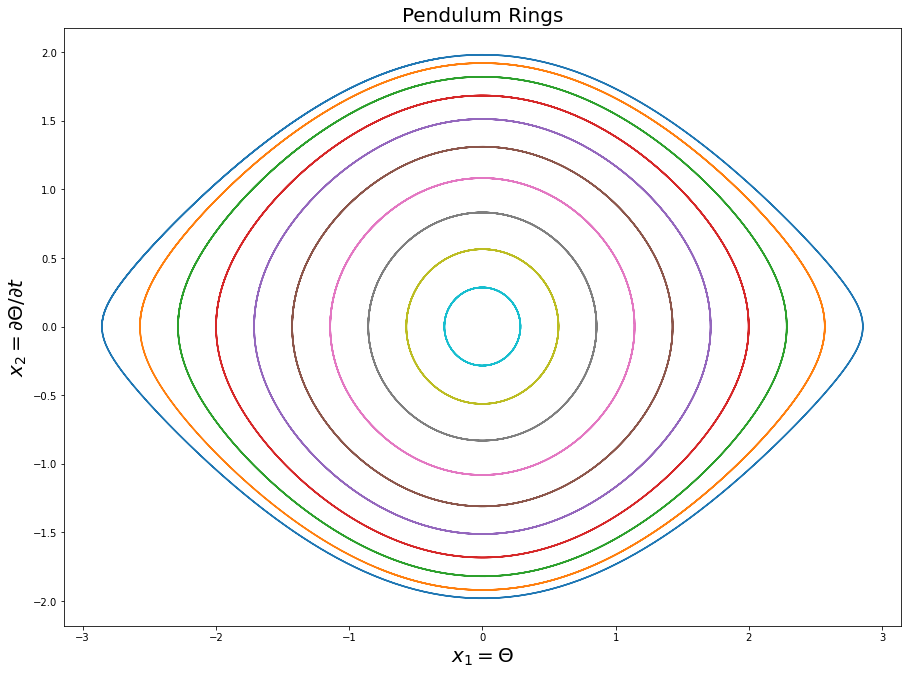

In [115]:
_ = plt.figure(figsize=(15,11))
for ii in range(0, 10):
    plt.plot(test_data[ii, 0, :], test_data[ii, 1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("Pendulum Rings", fontsize=20)
plt.show()

In [116]:
# Hyperparameters!

hyp_params = dict()
hyp_params['num_t_steps'] = 1500
hyp_params['phys_dim'] = 2
hyp_params['num_init_conds'] = 10
hyp_params['batch_size'] = 10 # MAJOR PARAMETER CHOICE
hyp_params['num_epochs'] = 500  # MAJOR PARAMETER CHOICE
hyp_params['window_size'] = None # MAJOR PARAMETER CHOICE

# Encoding/Decoding Layer Parameters
hyp_params['num_en_layers'] = 2 # MAJOR PARAMETER CHOICE
hyp_params['num_en_neurons'] = 80  # MAJOR PARAMETER CHOICE
hyp_params['latent_dim'] = 2

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['regfac'] = 3e-3

hyp_params['c1'] = 1 # coefficient autoencoder loss.
hyp_params['c2'] = 1 # coefficient of dmd loss. 
hyp_params['c3'] = 1 # coefficient of pred loss. 

In [117]:
# We must call the model first, then load the weights
model = DMDMachine(hyp_params)

In [118]:
model.autoencoder.encoder = keras.models.load_model("../models/encAeEx2_2021-01-19", compile=False)
model.autoencoder.decoder = keras.models.load_model("../models/decAeEx2_2021-01-19", compile=False)

In [119]:
test_run = model(test_data)

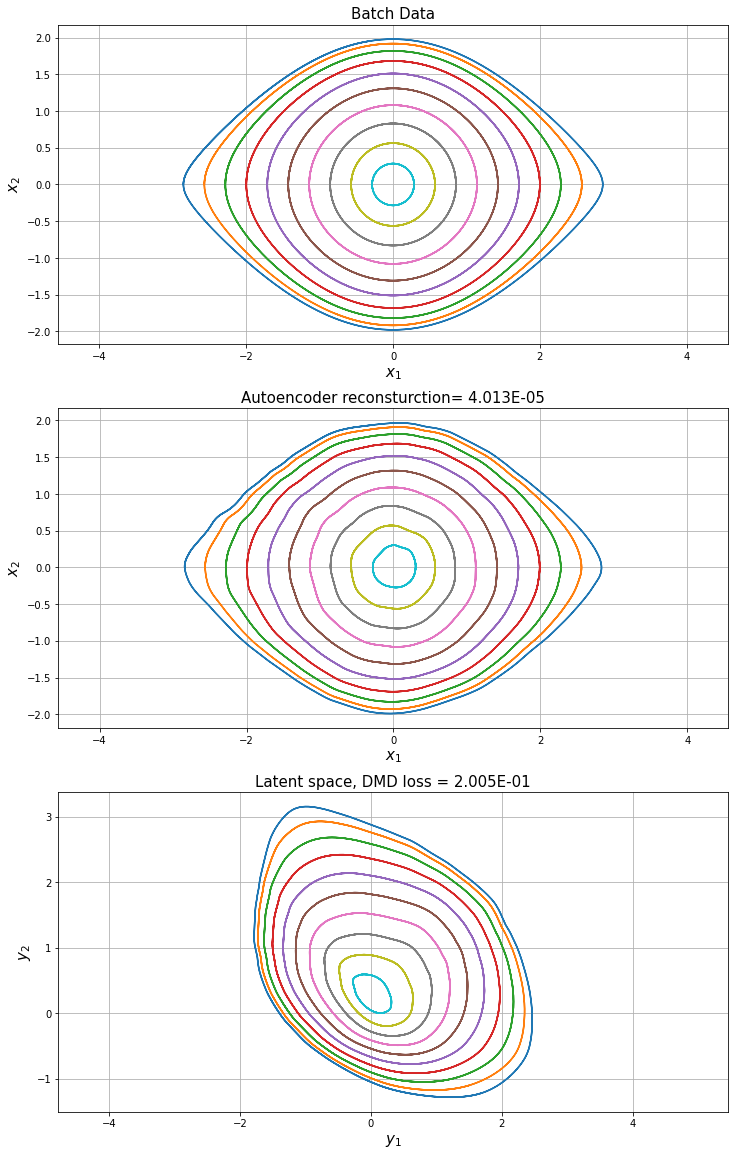

In [120]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

rect = fig.patch
rect.set_facecolor("white")

observed_data = test_data
for ii in range(0, observed_data.shape[0]):
    x1 = observed_data[ii, 0, :]
    x2 = observed_data[ii, 1, :]
    ax[0].plot(x1, x2, '-')
ax[0].grid()
ax[0].set_xlabel("$x_{1}$", fontsize=15)
ax[0].set_ylabel("$x_{2}$", fontsize=15)
ax[0].set_title("Batch Data", fontsize=15)

ae_data = test_run[0].numpy()
for ii in range(0, ae_data.shape[0]):
    x1 = ae_data[ii, 0, :]
    x2 = ae_data[ii, 1, :]
    ax[1].plot(x1, x2, '-')
ax[1].grid()
ax[1].set_xlabel("$x_{1}$", fontsize=15)
ax[1].set_ylabel("$x_{2}$", fontsize=15)

ae_loss = format(test_run[3].numpy(), ".3E")
ax[1].set_title("Autoencoder reconsturction= " + str(ae_loss), fontsize=15)

modeled_data = test_run[1].numpy()
for ii in range(0, modeled_data.shape[0]):
    modeled_rot = modeled_data[ii, :, :]
    x1 = modeled_rot[0]
    x2 = modeled_rot[1]
    ax[2].plot(x1, x2, '-')
ax[2].grid()
ax[2].set_xlabel("$y_{1}$", fontsize=15)
ax[2].set_ylabel("$y_{2}$", fontsize=15)

dmd_loss = format(test_run[2].numpy(), ".3E")
ax[2].set_title("Latent space, DMD loss = " + str(dmd_loss), fontsize=15)


_ = ax[0].axis("equal")
_ = ax[1].axis("equal")
_ = ax[2].axis("equal")

# Plot A eigenvalues. 

In [121]:
y = test_run[1]
y_reshape = model.reshape(y).numpy()
A = model.get_amat(y_reshape).numpy()
print(np.shape(y_reshape))

(20, 1500)


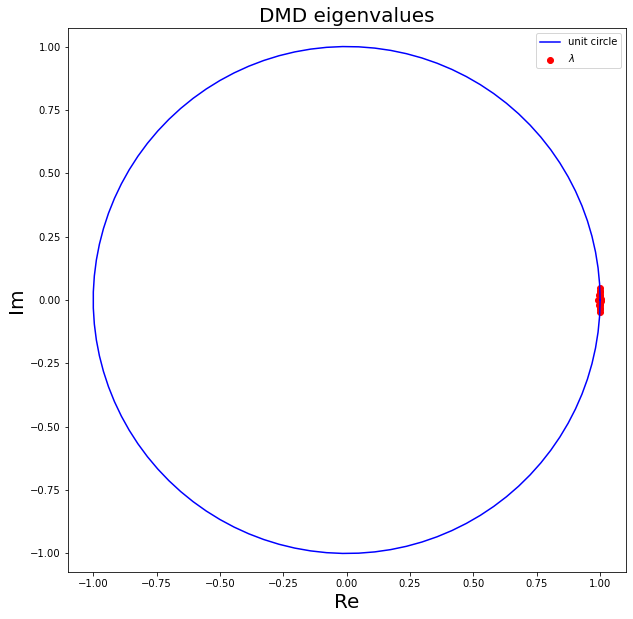

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))

rect = fig.patch
rect.set_facecolor("white")

# plot unit circle.
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(t), np.sin(t), "b", label="unit circle")

# compute the eigenvalues.
w, v = np.linalg.eig(A)

# plot the eigenvalues. 
ax.scatter(w.real, w.imag, color="r", label="$\lambda$")

ax.set_title("DMD eigenvalues", fontsize=20)
ax.set_ylabel("Im", fontsize=20)
ax.set_xlabel("Re", fontsize=20)
ax.set_ylim(-1.1, 1.1)
ax.set_xlim(-1.1, 1.1)

_ = plt.axis("equal")
_ = plt.legend()

# Predict 1500 steps forward. 

In [123]:
pred_step = 300

y_pred = np.zeros((y_reshape.shape[0], pred_step))
y_pred[:, 0] = y_reshape[:, 0]

A_exp = np.identity(A.shape[0])

for ii in range(1, pred_step):
    A_exp = A @ A_exp
    y_pred[:, ii] = A_exp @ y_pred[:, 0]

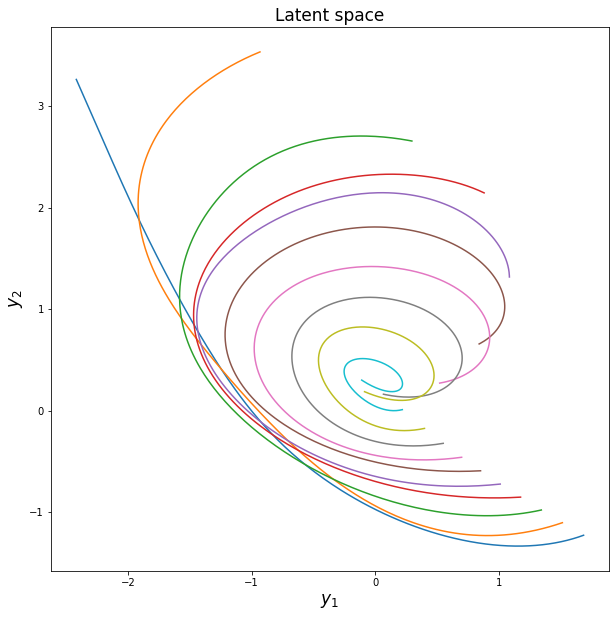

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
    
rect = fig.patch
rect.set_facecolor("white")
# set up the axes for the first plot

for ii in range(0, 10):
    x1 = y_pred[2* ii, :]
    x2 = y_pred[2* ii + 1, :]
    ax.plot(x1, x2)

_ = ax.set_xlabel("$y_{1}$", fontsize=17)
_ = ax.set_ylabel("$y_{2}$", fontsize=17)
_ = ax.set_title("Latent space", fontsize=17)


plt.savefig("./", facecolor=fig.get_facecolor())

# Model with longer trajectories. 

In [148]:
model = DMDMachine(hyp_params)
model.autoencoder.encoder = keras.models.load_model("../models/2021/pendulum/encAeEx2_longer_trajectory2021-01-19", compile=False)
model.autoencoder.decoder = keras.models.load_model("../models/2021/pendulum/decAeEx2_longer_trajectory2021-01-19", compile=False)

In [149]:
test_run = model(test_data)

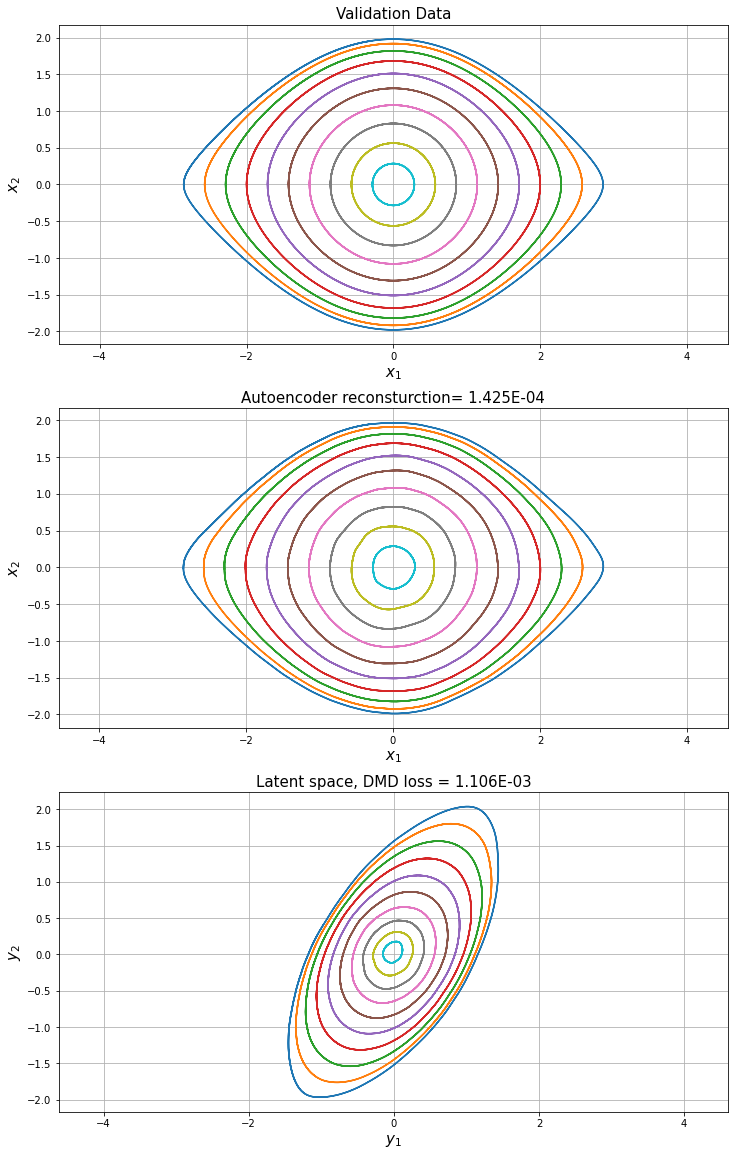

In [158]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

rect = fig.patch
rect.set_facecolor("white")

observed_data = test_data
for ii in range(0, observed_data.shape[0]):
    x1 = observed_data[ii, 0, :]
    x2 = observed_data[ii, 1, :]
    ax[0].plot(x1, x2, '-')
ax[0].grid()
ax[0].set_xlabel("$x_{1}$", fontsize=15)
ax[0].set_ylabel("$x_{2}$", fontsize=15)
ax[0].set_title("Validation Data", fontsize=15)

ae_data = test_run[0].numpy()
for ii in range(0, ae_data.shape[0]):
    x1 = ae_data[ii, 0, :]
    x2 = ae_data[ii, 1, :]
    ax[1].plot(x1, x2, '-')
ax[1].grid()
ax[1].set_xlabel("$x_{1}$", fontsize=15)
ax[1].set_ylabel("$x_{2}$", fontsize=15)

ae_loss = format(test_run[3].numpy(), ".3E")
ax[1].set_title("Autoencoder reconsturction= " + str(ae_loss), fontsize=15)

modeled_data = test_run[1].numpy()
for ii in range(0, modeled_data.shape[0]):
    modeled_rot = modeled_data[ii, :, :]
    x1 = modeled_rot[0]
    x2 = modeled_rot[1]
    ax[2].plot(x1, x2, '-')
ax[2].grid()
ax[2].set_xlabel("$y_{1}$", fontsize=15)
ax[2].set_ylabel("$y_{2}$", fontsize=15)

dmd_loss = format(test_run[2].numpy(), ".3E")
ax[2].set_title("Latent space, DMD loss = " + str(dmd_loss), fontsize=15)


_ = ax[0].axis("equal")
_ = ax[1].axis("equal")
_ = ax[2].axis("equal")

plt.savefig("../docs/images/pen_rings.png", facecolor=fig.get_facecolor())

In [151]:
y = test_run[1]
y_reshape = model.reshape(y).numpy()
A = model.get_amat(y_reshape).numpy()
print(np.shape(y_reshape))

(20, 1500)


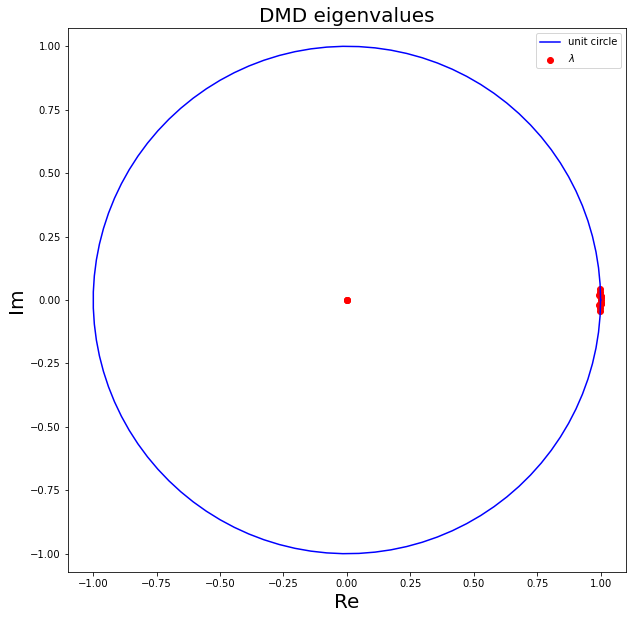

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))

rect = fig.patch
rect.set_facecolor("white")

# plot unit circle.
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(t), np.sin(t), "b", label="unit circle")

# compute the eigenvalues.
w, v = np.linalg.eig(A)

# plot the eigenvalues. 
ax.scatter(w.real, w.imag, color="r", label="$\lambda$")

ax.set_title("DMD eigenvalues", fontsize=20)
ax.set_ylabel("Im", fontsize=20)
ax.set_xlabel("Re", fontsize=20)
ax.set_ylim(-1.1, 1.1)
ax.set_xlim(-1.1, 1.1)

_ = plt.axis("equal")
_ = plt.legend()

In [153]:
pred_step = 1000

y_pred = np.zeros((y_reshape.shape[0], pred_step))
y_pred[:, 0] = y_reshape[:, 0]

A_exp = np.identity(A.shape[0])

for ii in range(1, pred_step):
    A_exp = A @ A_exp
    y_pred[:, ii] = A_exp @ y_pred[:, 0]

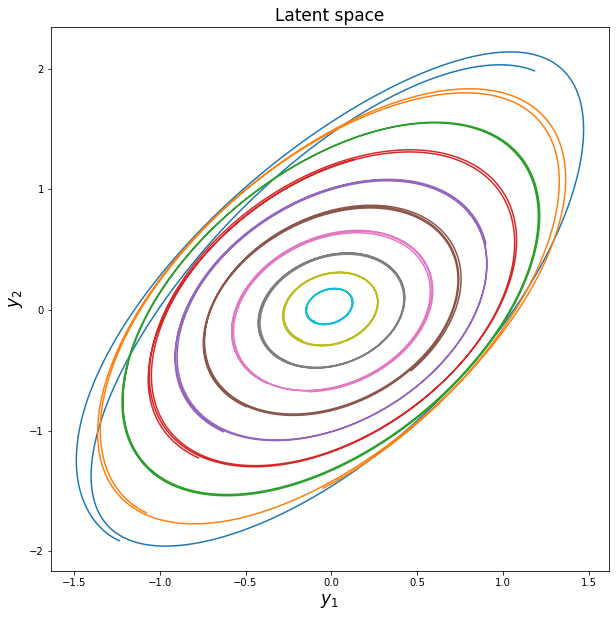

In [154]:
fig, ax = plt.subplots(figsize=(10, 10))
    
rect = fig.patch
rect.set_facecolor("white")
# set up the axes for the first plot

# initialize y_pred data
y_pred_mat = np.zeros((10, 2, 1000))

# loop over and plot. 
for ii in range(0, 10):
    x1 = y_pred[2* ii, :]
    x2 = y_pred[2* ii + 1, :]
    y_pred_mat[ii, 0, :] = y_pred[2* ii, :]
    y_pred_mat[ii, 1, :] = y_pred[2* ii + 1, :]
    ax.plot(x1, x2)

_ = ax.set_xlabel("$y_{1}$", fontsize=17)
_ = ax.set_ylabel("$y_{2}$", fontsize=17)
_ = ax.set_title("Latent space", fontsize=17)


#plt.savefig("./", facecolor=fig.get_facecolor())

In [155]:
x_ae = model.autoencoder.decode(y_pred_mat)

In [156]:
print(np.shape(x_ae))

(10, 2, 1000)


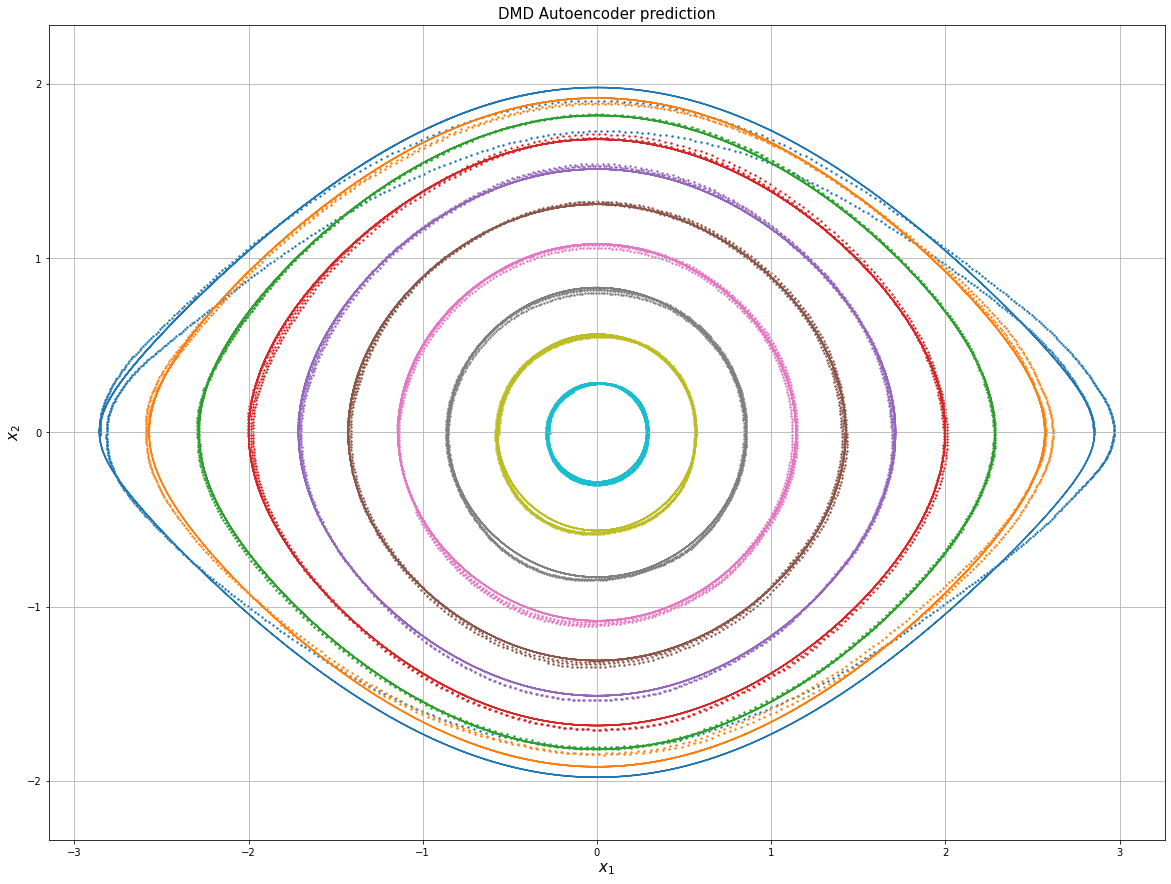

In [160]:
fig, ax = plt.subplots(figsize=(20, 15))

rect = fig.patch
rect.set_facecolor("white")

observed_data = test_data
for ii in range(0, observed_data.shape[0]):
    x1 = observed_data[ii, 0, :]
    x2 = observed_data[ii, 1, :]
    
    ax.scatter(x_ae[ii, 0, :], x_ae[ii, 1, :], s=2)
    ax.plot(x1, x2, '-')
ax.grid()
ax.set_xlabel("$x_{1}$", fontsize=15)
ax.set_ylabel("$x_{2}$", fontsize=15)
ax.set_title("DMD Autoencoder prediction", fontsize=15)


_ = ax.axis("equal")

plt.savefig("../docs/images/pen_rings_prediction.png", facecolor=fig.get_facecolor())